# motion segmentation with spatial transform

## dataset
- FBMS (only part of ground true)
- BMS (video format, not very good)
- DAVIS (not motion segmentation, but main motion object segmentation)
- CamouflagedAnimalDataset (not spatial transform)
- complexBackground-multilabel (not spatial transform)
- changedetection2012/2014 (not spatial transform)

In [1]:
import os
import glob
import torch.utils.data as td
import random
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch

project_dir=os.path.expanduser('~/git/torchseg')
os.chdir(project_dir)

from dataset.fbms_dataset import fbms_dataset
from models.motion_stn import motion_stn,motion_net
from models.motionseg.motion_fcn import motion_fcn,motion_fcn_stn
from dataset.dataset_generalize import image_normalizations
from utils.torch_tools import get_ckpt_path,load_ckpt
from utils.disc_tools import show_images, show_tensor_list

In [2]:
config={}
config['dataset']='FBMS'
config['net_name']='motion_unet'
config['train_path']='/media/sdb/CVDataset/ObjectSegmentation/FBMS/Trainingset'
config['val_path']='/media/sdb/CVDataset/ObjectSegmentation/FBMS/Testset'
config['frame_gap']=5
config['log_dir']=os.path.expanduser('~/tmp/logs/motion')
config['epoch']=30
config['init_lr']=1e-4
config['stn_loss_weight']=1.0
config['motion_loss_weight']=1.0
config['pose_mask_reg']=1.0
config['stn_object']='images'
config['note']='motion'+str(config['pose_mask_reg'])
config['save_model']=True
config['backbone_name']='vgg16'
config['upsample_layer']=3
config['freeze_layer']=1

normer=image_normalizations(ways='-1,1')
dataset_loaders={}
for split in ['train','val']:
    xxx_dataset=fbms_dataset(config,split,normalizations=normer)
    xxx_loader=td.DataLoader(dataset=xxx_dataset,batch_size=4,shuffle=True,drop_last=False,num_workers=2)
    dataset_loaders[split]=xxx_loader

if config['net_name'] in ['motion_stn','motion_net']:
    model=globals()[config['net_name']]() 
else:
    model=globals()[config['net_name']](config)
# support for cpu/gpu
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

log_dir = os.path.join(config['log_dir'], config['net_name'],
                       config['dataset'], config['note'])
checkpoint_path = get_ckpt_path(log_dir)
model=load_ckpt(model,checkpoint_path)


no checkpoint file given, auto find /home/yzbx/tmp/logs/motion/motion_stn/FBMS/motion1.0/2019-01-16___21-44-57/model-last-30.pkl


pose shape torch.Size([4, 1, 6])
theta tensor([[[ 0.9807, -0.0053,  0.0018],
         [-0.0001,  0.9788, -0.0063]],

        [[ 1.0014, -0.0058,  0.0042],
         [-0.0001,  0.9984, -0.0091]],

        [[ 0.9746, -0.0051,  0.0008],
         [-0.0012,  0.9760, -0.0069]],

        [[ 0.9613, -0.0068,  0.0005],
         [-0.0018,  0.9595, -0.0047]]],
       device='cuda:0', grad_fn=<ViewBackward>)
0 -0.13938709 0.478151 1.0 -1.0


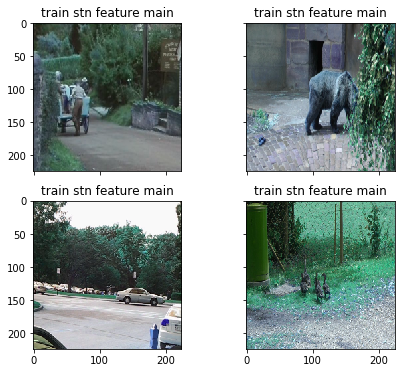

1 -0.13698855 0.4797824 1.0 -1.0


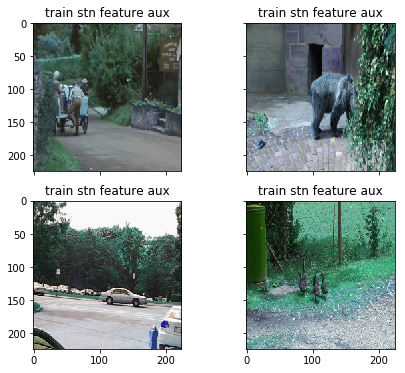

2 -0.13997017 0.47037116 0.99611825 -0.9955356


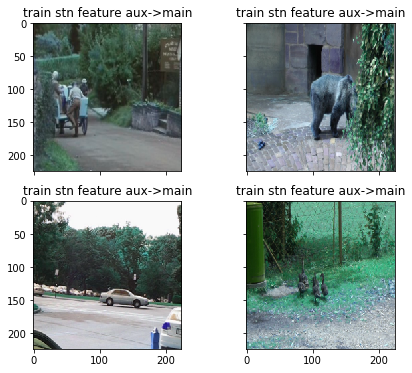

0 0.043531768176020405 0.20405085967838907 1 0


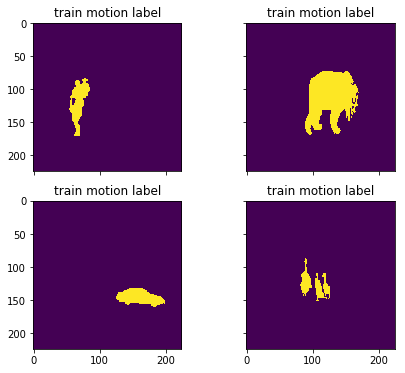

0 0.04813169 0.14594905 0.967845 3.069615e-10


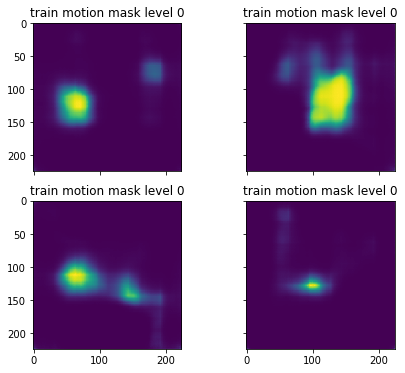

1 0.59954625 0.25579447 0.9919109 0.0012408415


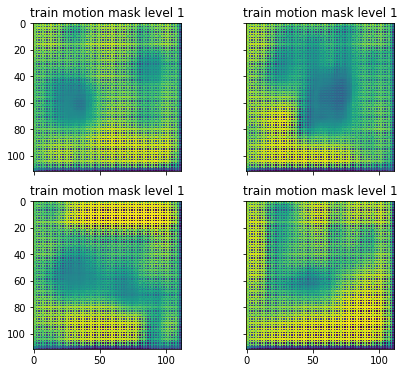

2 0.65935236 0.10196114 0.9593287 0.26914844


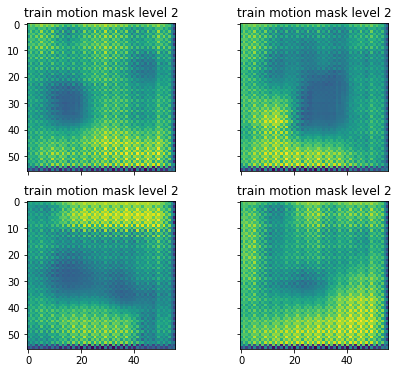

3 0.31749573 0.08972808 0.49594745 0.064762734


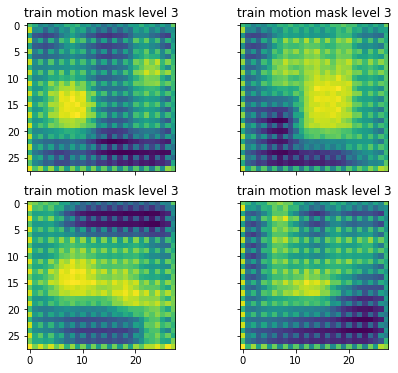

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 0.9983292 0.036142007 1.0000001 0.0


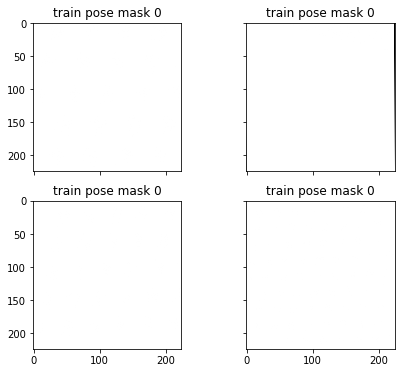

pose shape torch.Size([4, 1, 6])
theta tensor([[[ 9.4140e-01, -6.3177e-03, -1.2360e-03],
         [-1.7517e-03,  9.4190e-01, -4.3893e-03]],

        [[ 9.9074e-01, -4.2688e-03,  1.9894e-03],
         [ 6.3163e-05,  9.9434e-01, -1.1655e-02]],

        [[ 9.8997e-01, -4.9876e-03,  4.0224e-03],
         [ 1.2015e-03,  9.8652e-01, -9.7976e-03]],

        [[ 1.0035e+00, -5.9369e-03,  3.9045e-03],
         [ 1.1452e-03,  1.0015e+00, -1.0694e-02]]],
       device='cuda:0', grad_fn=<ViewBackward>)
0 -0.19753492 0.44884464 1.0 -1.0


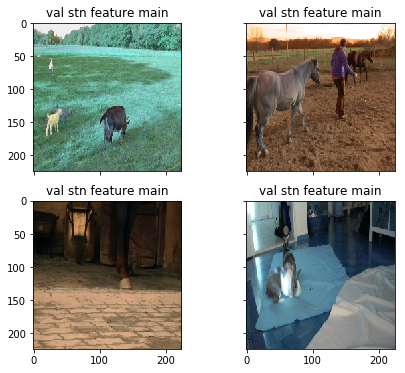

1 -0.1916336 0.4598047 1.0 -1.0


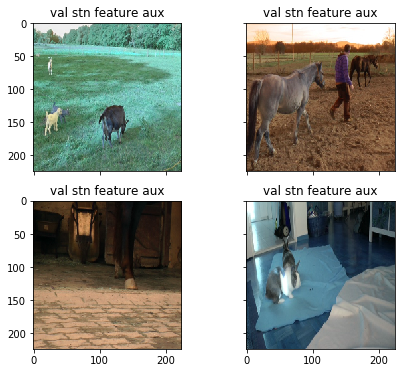

2 -0.19309488 0.45428142 1.0 -1.0


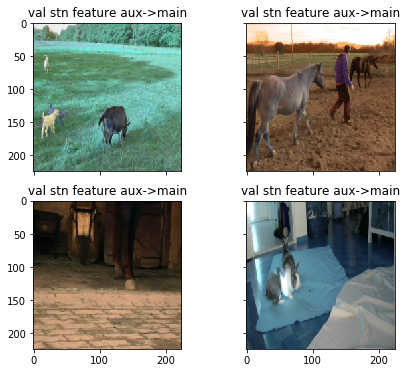

0 0.08261918048469388 0.275305741859358 1 0


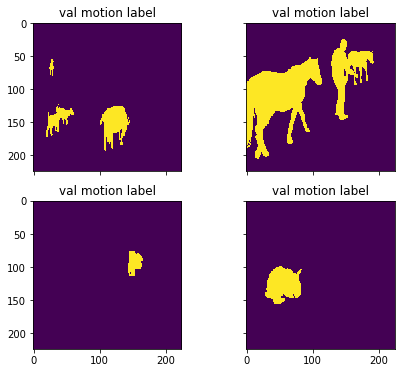

0 0.124430776 0.24847701 0.9689697 8.7079693e-10


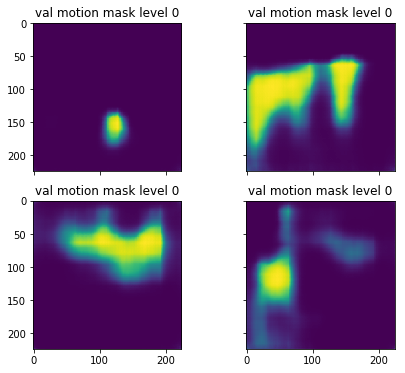

1 0.57529753 0.24570595 0.9968443 0.0025477987


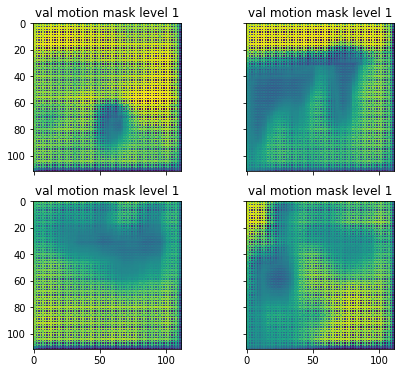

2 0.6388573 0.10844671 0.9521286 0.32650676


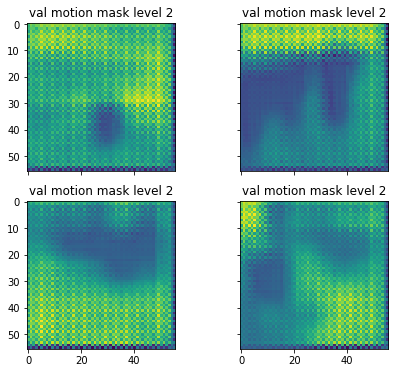

3 0.33834124 0.10185093 0.49390662 0.06676356


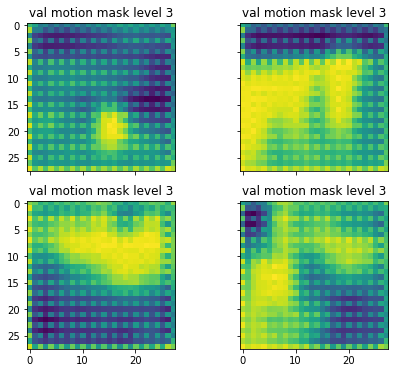

0 0.996667 0.05034832 1.0 0.0


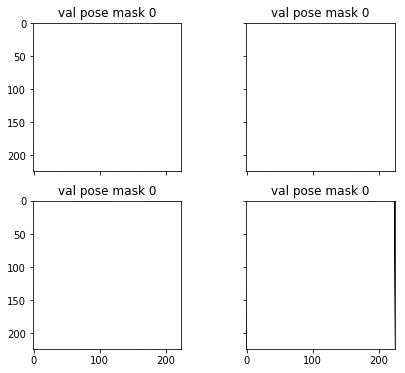

In [26]:
def stn_loss(features,motion,pose,pose_mask_reg=1.0):
    n=len(features)
    total_loss=0
    for i in range(n-1):
        theta=pose[:,i,:].view(-1,2,3)
        grid=F.affine_grid(theta,features[i+1].size())
        pose_mask=F.grid_sample(torch.ones_like(features[i+1]),grid)
        
        print('grid shape',grid.shape)
#         loss=F.l1_loss(features[0],features[i+1],reduction='none')
#         loss=F.l1_loss(features[0],features[i+1],reduction='none')
        loss=torch.abs(features[0]-features[i+1])
        print('l1_loss shape',loss.shape)
        loss=torch.clamp(loss,min=0,max=2.0)
        print('l1_loss clamp shape',loss.shape)
        print('features[0] shape',features[0].shape)
        print('features[1] shape',features[1].shape)
        print('pose mask shape',pose_mask.shape)
        
        print('l1_loss',torch.mean(loss).item())
        print('feature 0',torch.mean(features[0]).item(),torch.max(features[0]).item(),torch.min(features[0]).item())
        print('feature 1',torch.mean(features[1]).item(),torch.max(features[1]).item(),torch.min(features[1]).item())
        total_loss+=torch.mean(loss*(1-motion)*pose_mask)
        print('total_loss',total_loss.item())
        pose_reg_loss=pose_mask_reg*torch.mean(1-pose_mask)
        print('pose_reg_loss',pose_reg_loss.item())
        total_loss+=pose_reg_loss
    return total_loss

model.eval()
for split in ['train','val']:
    for frames,gt in dataset_loaders[split]:
        images = [torch.autograd.Variable(img.to(device).float()) for img in frames]
        labels=torch.autograd.Variable(gt.to(device).long())
        outputs=model.forward(images)
#         stn_loss_value=stn_loss(outputs['stn_images'],labels.float(),outputs['pose'],config['pose_mask_reg'])
        
        pose=outputs['pose']
        print('pose shape',pose.shape)
        stn_features=[images[0],images[1]]
        pose_masks=[]
        n=len(images)
        for i in range(n-1):
            theta=pose[:,i,:].view(-1,2,3)
            print('theta',theta)
            grid=F.affine_grid(theta,images[i+1].size())
            aux_feature=F.grid_sample(images[i+1],grid)
            pose_mask=F.grid_sample(torch.ones_like(images[i+1]),grid)
            stn_features.append(aux_feature)
            pose_masks.append(pose_mask)
            
        image_list_title=['main','aux','aux->main']
        image_list_title=[split+' stn feature '+note for note in image_list_title]
        show_tensor_list(stn_features,image_list_title,normer)
        
        show_tensor_list([gt],[split+' motion label'])
        
        show_tensor_list(outputs['masks'],[split+' motion mask level '+str(idx) for idx,t in enumerate(outputs['masks'])])
        
        show_tensor_list(pose_masks,[split+' pose mask ' +str(idx) for idx,t in enumerate(pose_masks)])

        break

0 101.8364490327381 57.62780948015076
1 102.59097809045493 59.02382298759929
2 102.38476230335884 57.93752141497391


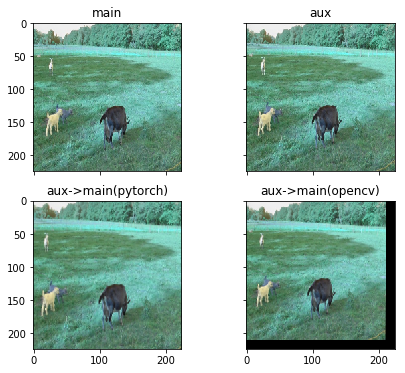

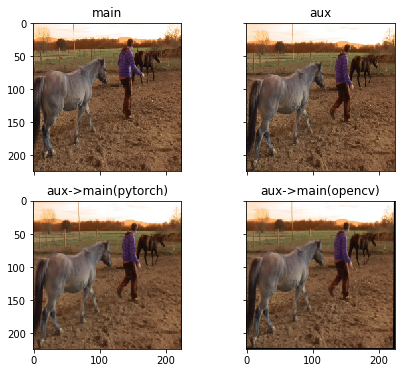

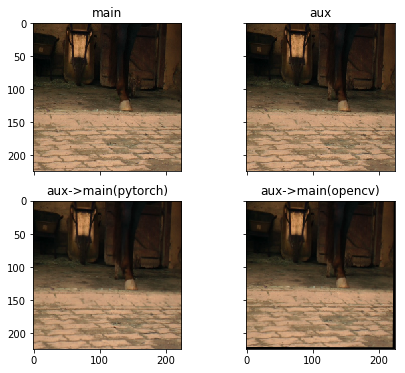

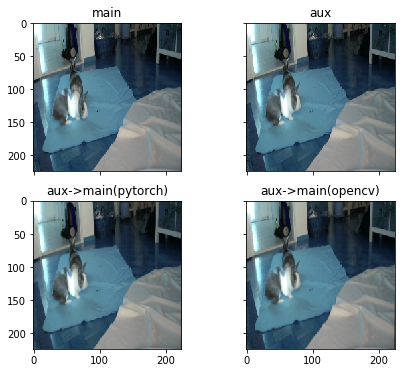

In [33]:
image_lists=[]
for idx,t in enumerate(stn_features):
    batch_images=t.data.cpu().numpy()
    batch_images=batch_images.transpose((0,2,3,1))
    batch_images=normer.backward(batch_images).astype(np.uint8)
    print(idx,np.mean(batch_images),np.std(batch_images))

    image_list=np.split(batch_images,4)
    image_list=[np.squeeze(img) for img in image_list]
    image_lists.append(image_list)

n=len(image_lists[0])
for idx in range(n):
    show_img_list=[image_lists[i][idx] for i in range(len(image_lists))]
    theta=pose[idx,0,:].view(2,3).data.cpu().numpy()
    aux_img=show_img_list[1]
    warp_img=cv2.warpAffine(aux_img,theta,aux_img.shape[0:2])
    show_img_list.append(warp_img)
    show_images(show_img_list,['main','aux','aux->main(pytorch)','aux->main(opencv)'])

In [34]:
print(pose.shape)
print(len(image_lists))

torch.Size([4, 1, 6])
3
